# Sources
https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

# Loading and Preprocessing Data


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Separating features and target
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium'] 

# Splitting the dataset into training and testing sets
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(features, target, test_size=0.2, random_state=42)


# Determining the Number of Features with RFE and optimizing parameters with GridSearch 

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, roc_auc_score

# Custom scorer using ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Split the dataset
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier parameters
base_model_params = {
    'use_label_encoder': False,
    'random_state': 42,
    'eval_metric': 'auc',
    'n_jobs': -1
}

# Parameter grid for Grid Search
param_grid = {
    'n_estimators': [10, 15, 20, 30],
    'max_depth': [2],
}

# Variables to track the best model and score
best_score = -np.inf
best_num_features = 0
best_model = None
best_support = None

# F1 scorer for model evaluation
f1_scorer = make_scorer(f1_score)

# Iterate through a range of features
for num_features in range(5, 8):
    # Recursive Feature Elimination
    rfe = RFE(estimator=XGBClassifier(**base_model_params), n_features_to_select=num_features, step=1)
    rfe.fit(X_train_grid, y_train_grid)

    # Grid Search with cross-validation
    grid_search = GridSearchCV(
        estimator=XGBClassifier(**base_model_params),
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=StratifiedKFold(5),
        n_jobs=-1
    )
    grid_search.fit(X_train_grid.iloc[:, rfe.support_], y_train_grid)

    # Evaluate the model
    X_test_selected = X_test_grid.iloc[:, rfe.support_]
    y_pred = grid_search.best_estimator_.predict(X_test_selected)
    test_f1 = f1_score(y_test_grid, y_pred)

    # Update the best model if the current one is better
    if test_f1 > best_score:
        best_score = test_f1
        best_num_features = num_features
        best_model = grid_search.best_estimator_
        best_support = rfe.support_

# Print the best parameters
def print_selected_parameters(model, param_grid):
    selected_params = {param: model.get_params()[param] for param in param_grid}
    print("Best parameters found: ", selected_params)

# Display results
print(f"Best number of features: {best_num_features}")
print_selected_parameters(best_model, param_grid.keys())
print("Best F1 score on test set: ", best_score)

# Final evaluation
X_test_selected = X_test_grid.iloc[:, best_support]
y_pred = best_model.predict(X_test_selected)
f1 = f1_score(y_test_grid, y_pred)
print(f"F1 score on test set: {f1:.3f}")


The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.


Best number of features: 5
Best parameters found:  {'n_estimators': 20, 'max_depth': 2}
Best F1 score on test set:  0.6896551724137931
F1 score on test set: 0.690


#### PDP plots

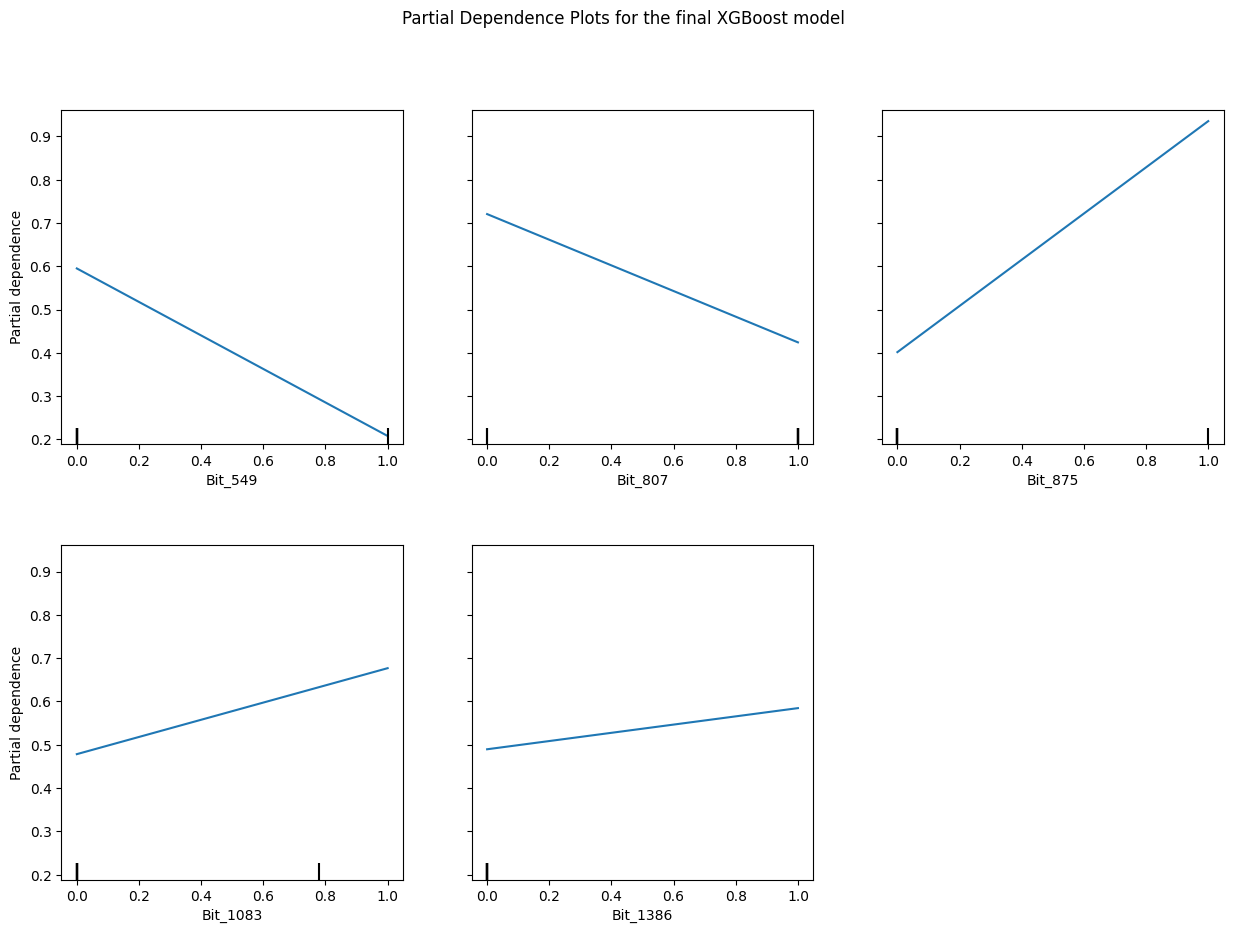

In [20]:
import os
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create 'charts' directory if it doesn't exist
charts_dir = 'charts'
os.makedirs(charts_dir, exist_ok=True)

# Get feature names of the selected features
selected_feature_names = X_train_grid.columns[best_support]

# Create the partial dependence plot
fig, ax = plt.subplots(figsize=(15, 10))
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_train_grid.iloc[:, best_support],
    features=selected_feature_names,
    kind='average',
    ax=ax,
    grid_resolution=20  # Higher resolution for finer plots
)

# Enhance plot aesthetics
pdp_display.figure_.suptitle('Partial Dependence Plots for the final XGBoost model')
pdp_display.figure_.subplots_adjust(hspace=0.3)

# Save the plot to the 'charts' directory
output_path = os.path.join(charts_dir, 'partial_dependence_plots.png')
plt.savefig(output_path, dpi=300)
plt.show()


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, classification_report

X_train_selected = X_train_grid.iloc[:, best_support]

# Evaluate the new best model (obtained from the latest hyperparameter tuning) on the training data
y_pred_train = best_model.predict(X_train_selected)
cm_train = confusion_matrix(y_train_grid, y_pred_train)
tn, fp, fn, tp = cm_train.ravel()

# Calculate performance metrics for the training data
sensitivity_train = tp / (tp + fn) if (tp + fn) > 0 else 0  # Added zero division check
specificity_train = tn / (tn + fp) if (tn + fp) > 0 else 0  # Added zero division check
accuracy_train = accuracy_score(y_train_grid, y_pred_train)
precision_train = precision_score(y_train_grid, y_pred_train, zero_division=0) 
npv_train = tn / (tn + fn) if (tn + fn) > 0 else 0  
f1_train = f1_score(y_train_grid, y_pred_train)
mcc_train = matthews_corrcoef(y_train_grid, y_pred_train)

# Printing results for the training data
print("Classification report on training data:")
print(classification_report(y_train_grid, y_pred_train))
print("Confusion Matrix on training data:", cm_train)
print(f"Sensitivity: {sensitivity_train:.2f}")
print(f"Specificity: {specificity_train:.2f}")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"Negative Predictive Value: {npv_train:.2f}")
print(f"F1 Score: {f1_train:.2f}")
print(f"MCC: {mcc_train:.2f}")


Classification report on training data:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84        54
           1       0.95      0.67      0.78        54

    accuracy                           0.81       108
   macro avg       0.85      0.81      0.81       108
weighted avg       0.85      0.81      0.81       108

Confusion Matrix on training data: [[52  2]
 [18 36]]
Sensitivity: 0.67
Specificity: 0.96
Accuracy: 0.81
Precision: 0.95
Negative Predictive Value: 0.74
F1 Score: 0.78
MCC: 0.66


# Testing on unseen data

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Transform the unseen data using the selected features
X_test_unseen_selected = X_test_unseen.iloc[:, best_support]

# Predict using the best model found from grid search
y_pred_unseen = best_model.predict(X_test_unseen_selected)

# Evaluate the predictions
conf_matrix = confusion_matrix(y_test_unseen, y_pred_unseen)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate evaluation metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
accuracy = accuracy_score(y_test_unseen, y_pred_unseen)
precision = precision_score(y_test_unseen, y_pred_unseen, zero_division=0)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
mcc = matthews_corrcoef(y_test_unseen, y_pred_unseen)
f1 = f1_score(y_test_unseen, y_pred_unseen)

# Print the results
print(f"Sensitivity (Recall or True Positive Rate): {sensitivity:.2f}")
print(f"Specificity (True Negative Rate): {specificity:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Positive Predictive Value): {precision:.2f}")
print(f"Negative Predictive Value: {npv:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")


Sensitivity (Recall or True Positive Rate): 0.62
Specificity (True Negative Rate): 0.84
Accuracy: 0.74
Precision (Positive Predictive Value): 0.77
Negative Predictive Value: 0.73
F1 Score: 0.69
Matthews Correlation Coefficient: 0.48


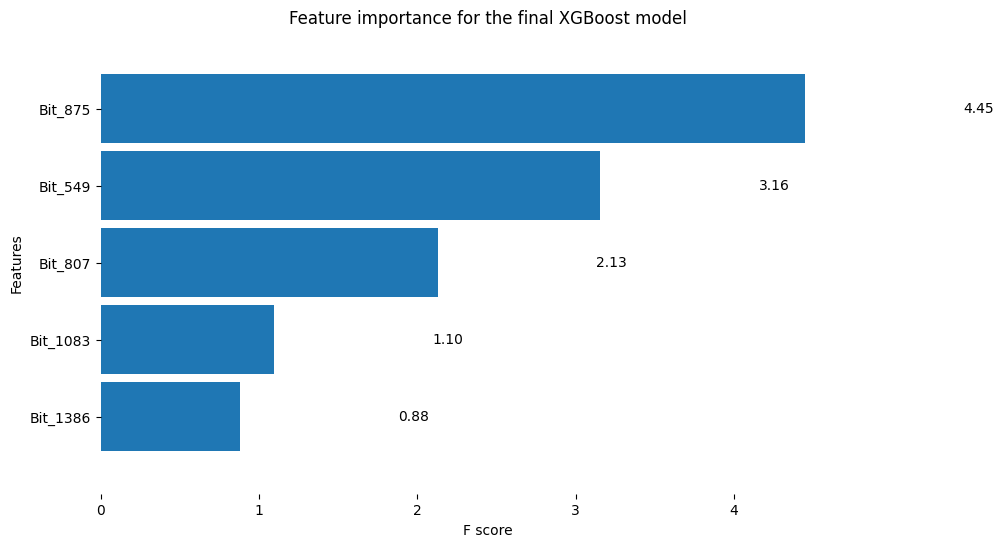

In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt
import os

# Create 'charts' directory if it doesn't exist
charts_dir = 'charts'
os.makedirs(charts_dir, exist_ok=True)

# Create a plot for feature importances
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(
    booster=best_model,
    height=0.9,
    ax=ax,
    importance_type='gain',
    max_num_features=12,
    title='Feature Importance for the Final XGBoost Model',
    show_values=True
)

# Format text elements in the plot
for text in ax.texts:
    value = float(text.get_text())
    text.set_text(f"{value:.2f}")

# Remove grid lines and set spine visibility to false
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# Save the plot to the 'charts' directory
plot_path = os.path.join(charts_dir, 'feature_importance_gain.png')
plt.savefig(plot_path, dpi=300)
plt.show()


#  ROC and the precision-recall curve for training data.

Features used for model training: ['Bit_549', 'Bit_807', 'Bit_875', 'Bit_1083', 'Bit_1386']
Features in X_train_selected: ['Bit_549', 'Bit_807', 'Bit_875', 'Bit_1083', 'Bit_1386']


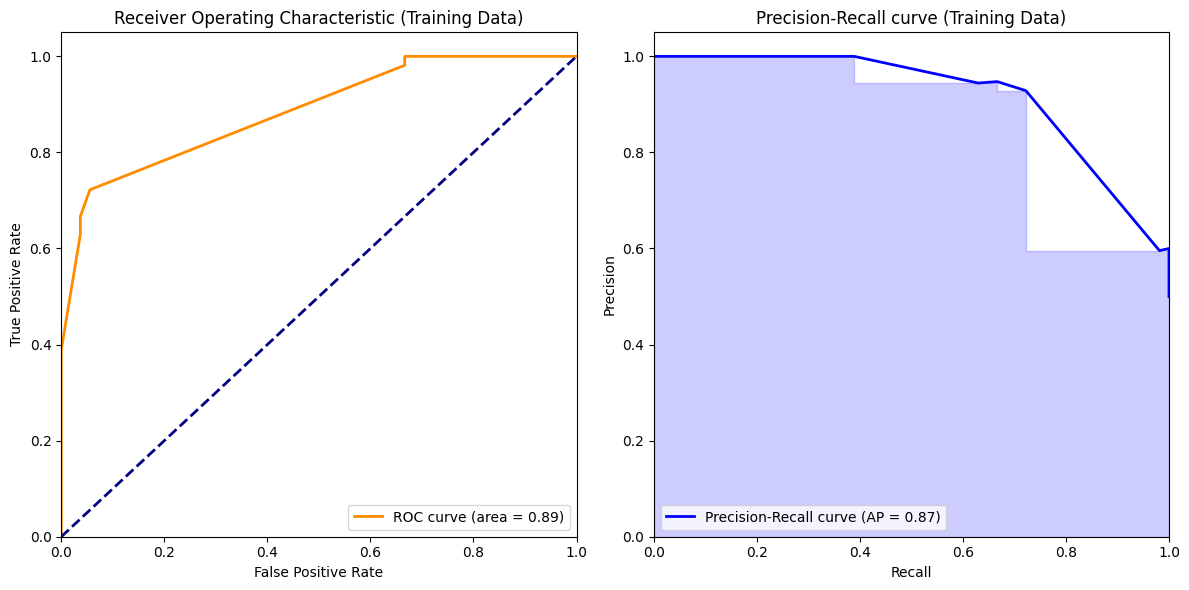

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import os

# Display the features used for model training and the selected features
print("Features used for model training:", best_model.get_booster().feature_names)
print("Features in X_train_selected:", X_train_selected.columns.tolist())

# Predict probabilities for the positive class
y_scores_train = best_model.predict_proba(X_train_selected)[:, 1]

# Ensure the lengths of actual and predicted values match
if len(y_train_grid) == len(y_scores_train):
    # Calculate ROC Curve metrics
    fpr_train, tpr_train, thresholds_roc = roc_curve(y_train_grid, y_scores_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Calculate Precision-Recall Curve metrics
    precision_train, recall_train, thresholds_pr = precision_recall_curve(y_train_grid, y_scores_train)
    average_precision_train = average_precision_score(y_train_grid, y_scores_train)

    # Create plots
    plt.figure(figsize=(12, 6))

    # Subplot 1: ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Training Data)')
    plt.legend(loc="lower right")

    # Subplot 2: Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_train, precision_train, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision_train)
    plt.fill_between(recall_train, precision_train, step='post', alpha=0.2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve (Training Data)')
    plt.legend(loc="lower left")

    plt.tight_layout()

    # Ensure the 'charts' directory exists
    output_directory = 'charts'
    os.makedirs(output_directory, exist_ok=True)

    # Save the figure
    plot_path = os.path.join(output_directory, 'roc_precision_recall_training.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()
else:
    print("Mismatch in the number of training samples and predictions, cannot plot ROC or Precision-Recall curve.")


# Plotting the learning curve

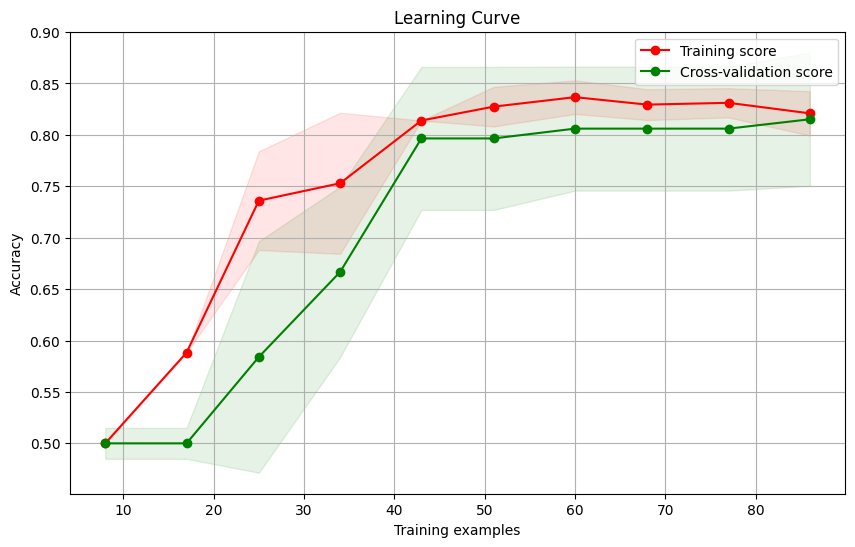

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold
import os

# `new_best_model` and `X_train_selected` have been defined from the previous context

# Set up the parameters for the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,  # Use the new best model from hyperparameter tuning
    X=X_train_selected,  # Ensure this uses the correct selected features
    y=y_train_grid,  # Training labels
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

# Creating the plot
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)

# Check if the directory exists and create it if it doesn't
output_directory = 'charts'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the figure
plt.savefig(f'{output_directory}/learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()


# ROC Curve, Precision-Recall Curve on unseen data


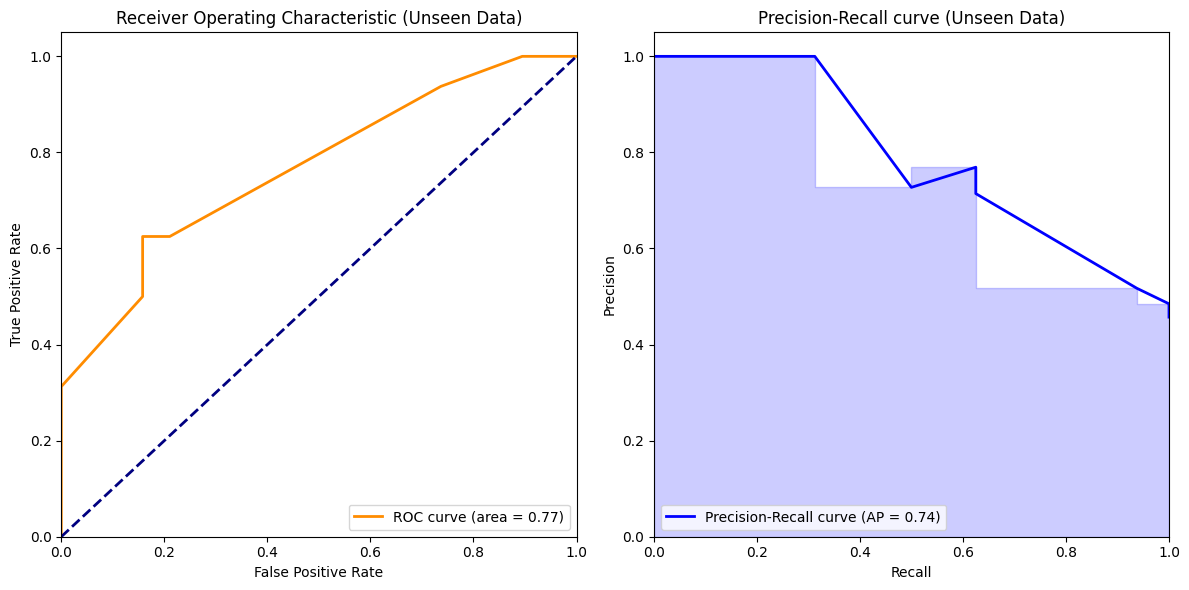

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import os

# Ensure the data is prepared similarly to the training phase
y_scores_unseen = best_model.predict_proba(X_test_unseen_selected)[:, 1]

# ROC Curve for unseen data
fpr_unseen, tpr_unseen, thresholds_roc_unseen = roc_curve(y_test_unseen, y_scores_unseen)
roc_auc_unseen = auc(fpr_unseen, tpr_unseen)

# Precision-Recall Curve for unseen data
precision_unseen, recall_unseen, thresholds_pr_unseen = precision_recall_curve(y_test_unseen, y_scores_unseen)
average_precision_unseen = average_precision_score(y_test_unseen, y_scores_unseen)

# Plotting both ROC and Precision-Recall Curve
plt.figure(figsize=(12, 6))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_unseen, tpr_unseen, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_unseen)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Unseen Data)')
plt.legend(loc="lower right")

# Subplot 2: Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_unseen, precision_unseen, color='blue', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision_unseen)
plt.fill_between(recall_unseen, precision_unseen, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve (Unseen Data)')
plt.legend(loc="lower left")

plt.tight_layout()

# Check if the directory exists
output_directory = 'charts'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the figure
plt.savefig(f'{output_directory}/roc_precision_recall_unseen.png', dpi=300, bbox_inches='tight')

# display the plot
plt.show()


# Shap values for feature interaction plots

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html#

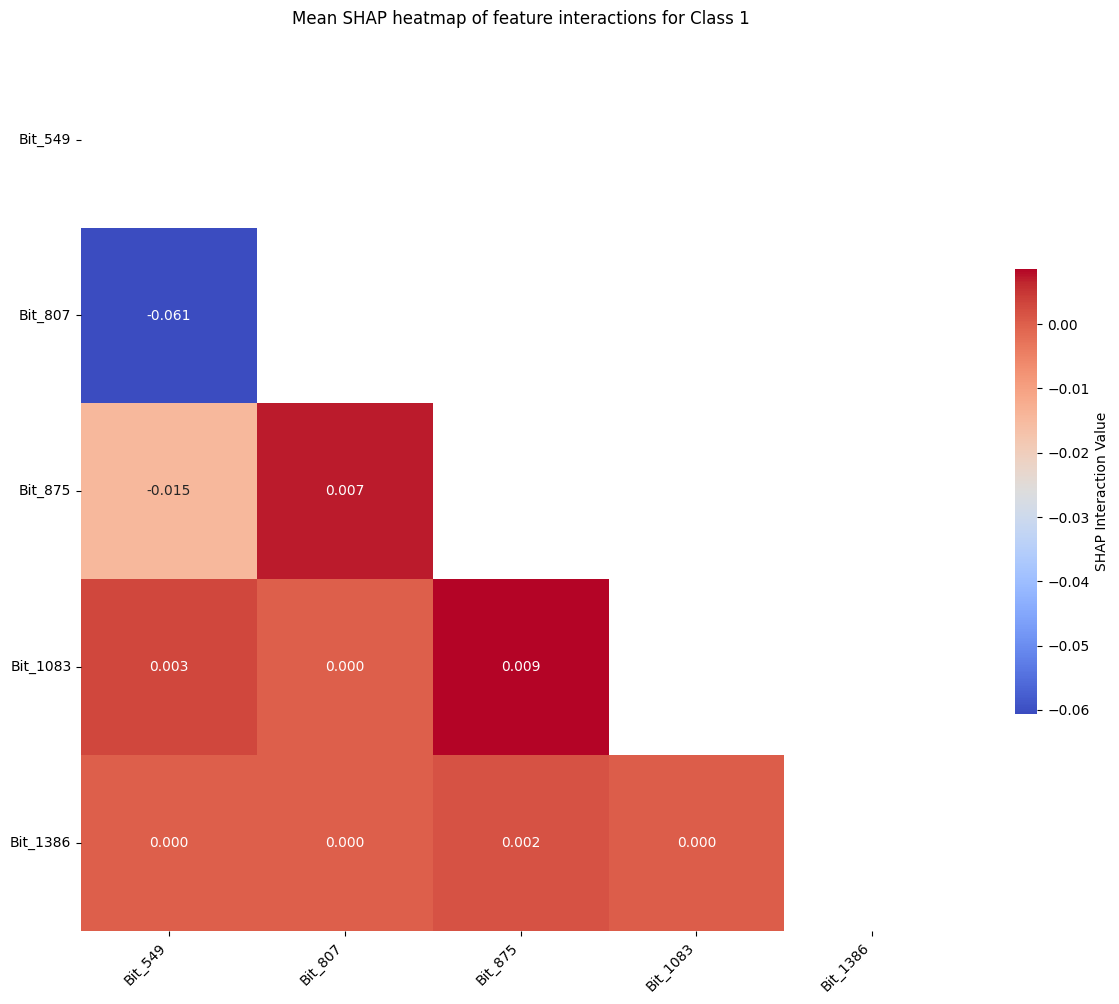

In [15]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load model and data
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_selected)

# Compute SHAP interaction values for the positive class (class 1)
if isinstance(shap_values, list):
    shap_interaction_values = explainer.shap_interaction_values(X_train_selected)[1]
else:
    shap_interaction_values = explainer.shap_interaction_values(X_train_selected)

# Aggregate interaction values across all samples (mean over the 0th axis)
mean_shap_interaction_values = np.mean(shap_interaction_values, axis=0)

# Mask the upper triangle and diagonal to focus only on interaction pairs
mask = np.triu(np.ones_like(mean_shap_interaction_values, dtype=bool))

# Set up a large figure for clearer visualization
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(mean_shap_interaction_values, mask=mask, annot=True, cmap='coolwarm',
            cbar_kws={'shrink': 0.5, 'label': 'SHAP Interaction Value'},  # Customize colorbar
            square=True, fmt=".3f",  # Adjusted to format numbers to three decimal places
            xticklabels=X_train_selected.columns,
            yticklabels=X_train_selected.columns)

# Improve aesthetics
plt.title("Mean SHAP heatmap of feature interactions for Class 1", pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust the layout to make room for label rotations

# Save the figure with high resolution
plt.savefig('charts/mean_feature_interaction_heatmap_class_1.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# Inspecting Features

In [ ]:
import pandas as pd
import os

# Load the data
file_path = 'aggregated_plants.csv'
df = pd.read_csv(file_path)

# List of important features from the model 
important_features = [
    'Bit_875',
    'Bit_549',
    'Bit_807',
    'Bit_1083',
    'Bit_1386',
]



save_dir = './features/' 

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterating through each important feature
for feature in important_features:
    # Filter rows where the feature is present (1)
    feature_present_df = df[df[feature] == 1]
    
    # Drop all other 'Bit_' columns except the one in focus
    columns_to_drop = [col for col in df.columns if col.startswith('Bit_') and col != feature]
    feature_present_df = feature_present_df.drop(columns=columns_to_drop)
    
    # Define the new file path
    new_file_path = save_dir + f"{feature}.csv"
    
    # Save the filtered rows to a new CSV file
    feature_present_df.to_csv(new_file_path, index=False)
    
    print(f"Rows where {feature} is present and all other Bit_ columns are removed have been saved to '{new_file_path}'")


# Adding SMILES-Chemical pairs, Chemical names, and Concentrations


In [ ]:
import pandas as pd
import os
import ast
from collections import Counter
import glob

def safe_literal_eval(s):
    dict_strings = [d.strip() for d in s.split(';') if d.strip()]
    all_dicts = {}
    for dict_str in dict_strings:
        try:
            all_dicts.update(ast.literal_eval(dict_str))
        except Exception as e:
            print(f"Failed to parse part: {dict_str}\nError: {e}")
    return all_dicts

def preprocess_bit_name(bit_name):
    bit_number = bit_name.replace('Bit_', '').replace('.csv', '')
    return int(bit_number)

features_dir = 'features/'
reorganized_plants_path = 'reorganized_plants_filtered.csv'
combined_chemicals_path = '../initial_data/matched_chemicals_final_manual.csv'

reorganized_plants_df = pd.read_csv(reorganized_plants_path)
combined_chemicals_df = pd.read_csv(combined_chemicals_path)  # Load the combined chemicals data
reorganized_plants_df = reorganized_plants_df.drop_duplicates(subset=['Plant_Species', 'Chemical'])

assert 'Concentration' in reorganized_plants_df.columns, "Concentration column not found in the reorganized plants data!"

bit_files = glob.glob(os.path.join(features_dir, 'Bit_*.csv'))

for bit_file in bit_files:
    bit_name = os.path.basename(bit_file)
    bit_name = bit_name.replace('.csv', '')

    new_bit_file = os.path.join(features_dir, f"{bit_name}_updated.csv")

    bit_df = pd.read_csv(bit_file)

    bit_df['BitInterpretations'] = bit_df['BitInterpretations'].apply(safe_literal_eval)

    if 'SMILES' not in bit_df.columns:
        bit_df.insert(3, 'SMILES', '')
    if 'Chemical' not in bit_df.columns:
        bit_df.insert(4, 'Chemical', '')
    if 'Chemical_name' not in bit_df.columns:  # Add Chemical_name column 
        bit_df.insert(5, 'Chemical_name', '')

    expanded_rows = []

    for index, row in bit_df.iterrows():
        plant_species = row['Plant_Species']
        bit_interpretations = row['BitInterpretations']
        bit_number = preprocess_bit_name(bit_name)

        if bit_number in bit_interpretations:
            interpreted_bit = str(bit_interpretations[bit_number])
        else:
            interpreted_bit = ''

        matching_rows = reorganized_plants_df[
            (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower()) &
            (reorganized_plants_df[bit_name] == 1)]

        for _, match in matching_rows.iterrows():
            new_row = row.copy()
            new_row['SMILES'] = match['SMILES']
            new_row['Chemical'] = match['Chemical']
            new_row['BitInterpretations'] = interpreted_bit
            new_row['Chemical_name'] = combined_chemicals_df[combined_chemicals_df['SMILES'] == match['SMILES']]['Chemical Name'].iloc[0]

            # Ensure matching both 'SMILES' and 'Plant_Species'
            concentration_match = reorganized_plants_df[
                (reorganized_plants_df['SMILES'] == match['SMILES']) & 
                (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower())
            ]['Concentration']

            new_row['Concentration'] = concentration_match.iloc[0] if not concentration_match.empty else None

            expanded_rows.append(new_row)

    expanded_bit_df = pd.DataFrame(expanded_rows)

    # Remove the 'Chemical' column as it's no longer needed
    expanded_bit_df = expanded_bit_df.drop(columns=['Chemical'])

    expanded_bit_df = expanded_bit_df.sort_values(by='Chemical_name', ascending=True)

    expanded_bit_df.to_csv(new_bit_file, index=False)

    print(f"Updated {bit_name} with individual SMILES, Chemical names from combined file has been saved to {new_bit_file}")

print("All Bit files have been processed and updated with individual SMILES-Chemical pairs, Chemical names, and Concentrations.")


# Remove all rare chemicals which appear only once (not interesting for the domain)

In [ ]:
import pandas as pd
import os
import glob

features_dir = 'features/'

# Gather all updated CSV files
updated_files = glob.glob(os.path.join(features_dir, '*_updated.csv'))

# Process each CSV file independently
for file in updated_files:
    df = pd.read_csv(file)
    # Count the occurrences of each chemical name in this specific file
    chemical_name_counts = df['Chemical_name'].value_counts()
    # Identify chemical names that appear more than once
    chemicals_to_keep = chemical_name_counts[chemical_name_counts > 1].index
    
    # Filter the dataframe to only include rows with chemical names that appear more than once
    filtered_df = df[df['Chemical_name'].isin(chemicals_to_keep)]
    
    # Save the filtered dataframe back to the same CSV file
    filtered_df.to_csv(file, index=False)
    print(f"Filtered data saved back to {file}")

print("All updated CSV files have been re-processed to exclude unique chemical names.")


# Visualisation of molecular features

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw
import os

important_features = [
    'Bit_875',
    'Bit_549',
    'Bit_807',
    'Bit_1083',
    'Bit_1386',
]


# Define the output folder for SVG images
output_folder = 'visualizations'  # Adjust as needed
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

for feature in important_features:
    bit_number = feature.split('_')[1]  # Extract the bit number from the feature name
    updated_file_path = f'features/{feature}_updated.csv'  # Construct the file path dynamically
    
    try:
        df = pd.read_csv(updated_file_path)
    except FileNotFoundError:
        print(f"File {updated_file_path} not found, skipping.")
        continue

    bit_to_visualize = int(bit_number)  # Convert the bit number to an integer

    for idx, row in df.drop_duplicates(subset='SMILES').iterrows():
        smiles = row['SMILES']
        chemical_name = row.get('Chemical_name', 'Unnamed_Chemical')  # Default name if not present
        plant_species = row.get('Plant_Species', 'UnknownSpecies').split()[:2]  # Get first two words of plant species
        concentration = row.get('Concentration', 0)  # Get concentration value, default to 0 if not present

        # Generate a molecule from the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if not mol: continue  # Skip if molecule can't be created

        # Generate a Morgan fingerprint and save information about the bits that are set
        bit_info = {}
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bit_info)

        if bit_to_visualize in bit_info:
            # Visualize the first example of the bit setting
            whichExample = 0  # Always use the first example
            img = Draw.DrawMorganBit(mol, bit_to_visualize, bit_info, whichExample=whichExample, useSVG=True)
            
            # Ensure the chemical name, plant species, and concentration are filesystem safe
            safe_chemical_name = ''.join(e for e in chemical_name if e.isalnum())
            safe_plant_species = '_'.join(''.join(e for e in word if e.isalnum()) for word in plant_species)
            safe_concentration = ''.join(e for e in str(concentration) if e.isdigit() or e == '.')  # Convert float to string

            # Filename includes the bit, chemical name, plant species, and concentration
            svg_file_path = os.path.join(output_folder, f"bit_{bit_to_visualize}_{safe_chemical_name}_{safe_plant_species}_conc_{safe_concentration}.svg")
            with open(svg_file_path, "w") as svg_file:
                svg_file.write(img.data)
            print(f"Saved SVG image to {svg_file_path}")


# Get the names of the chemicals contatinig the feature

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('features/Bit_1386_updated.csv')

# Ensure that the column you're interested in is named 'Chemical name'
# Convert all names in 'Chemical name' to lowercase
lowercase_names = df['Chemical_name'].str.lower()

# Get unique names
unique_names = lowercase_names.unique()

# Join the unique names into a comma-separated string
names_string = ', '.join(unique_names)

# Print the result
print(names_string)


## Convert SVG to PNG

In [ ]:
import os
import cairosvg

# Directory containing the SVG files
directory = 'visualizations'

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".svg"):
        # Construct full file path
        svg_path = os.path.join(directory, filename)
        # Define the output file path
        png_path = os.path.join(directory, f"{os.path.splitext(filename)[0]}.png")
        # Convert SVG to PNG with 300 dpi
        cairosvg.svg2png(url=svg_path, write_to=png_path, dpi=300)
        print(f"Converted {svg_path} to {png_path}")
